In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

if torch.cuda.is_available():
    device = "cuda"
elif torch.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

'cuda'

In [32]:
class nfl_dataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        
        if self.transform:
            sample = self.transform(sample)
        
        sample = torch.tensor(sample, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)
        
        return sample, target

In [33]:
class MDN(nn.Module):
    def __init__(self, input_size, hidden_layers, num_gaussians, dropout_rate):
        super(MDN, self).__init__()
        
        # hyperparameters
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.num_gaussians = num_gaussians
        
        # convert hidden layer parameters to linear layers
        layers = []
        layer_sizes = [input_size] + hidden_layers
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
        self.hidden_layers_net = nn.ModuleList(layers)
        
        # relu and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        
        # mixture distribution layers
        self.pi_layer = nn.Linear(64, num_gaussians)
        self.mu_layer = nn.Linear(64, num_gaussians)
        self.sigma_layer = nn.Linear(64, num_gaussians)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):

        for layer in self.hidden_layers_net:
            x = layer(x)
            x = self.relu(x)
            x = self.dropout(x)
        
        pi = self.softmax(self.pi_layer(x))
        mu = self.mu_layer(x)
        
        # stabilize sigma computation
        sigma_raw = self.sigma_layer(x)
        sigma = torch.nn.functional.softplus(torch.clamp(sigma_raw, -10, 10)) + 1e-6
        
        return pi, mu, sigma
    
    def mdn_loss(self, pi, mu, sigma, target):
        log_2pi = torch.log(2 * torch.pi * sigma**2)
        log_gaussian = -0.5 * (log_2pi + ((target - mu) / sigma) ** 2)
        weighted_log_probs = torch.log(pi + 1e-8) + log_gaussian
        log_likelihood = torch.logsumexp(weighted_log_probs, dim=1)
        loss = -log_likelihood.mean()
        
        return loss

In [34]:
def train_model(model, train_loader, test_loader, optimizer, num_epochs, device):
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            pi, mu, sigma = model(data)
            loss = model.mdn_loss(pi, mu, sigma, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                pi, mu, sigma = model(data)
                loss = model.mdn_loss(pi, mu, sigma, target)
                test_loss += loss.item()
        
        # Calculate average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses
        

In [ ]:
def load_data(filepath):
    data = pd.read_csv(filepath, delimiter=',')

    # train test split data
    features = data.iloc[:, 2:-1]
    targets = data.iloc[:, -1:]
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

    # scaled x data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # scale y data
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler, y_scaler

In [36]:
# load in data
filepath = r'C:\Users\Jona\Desktop\tuxff\tuxff-models\data\data_mdn.csv'
data = pd.read_csv(filepath, delimiter=',')

# train test split data
features = data.iloc[:, 2:-1]
targets = data.iloc[:, -1:]
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# scaled x data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# scale y data
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# create dataset
train_dataset = nfl_dataset(X_train_scaled, y_train_scaled)
test_dataset = nfl_dataset(X_test_scaled, y_test_scaled)

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

X_train_scaled.shape

(17872, 65)

Epoch 0/101, Train Loss: 1.2504, Test Loss: 0.9801
Epoch 10/101, Train Loss: 0.8139, Test Loss: 0.7250
Epoch 20/101, Train Loss: 0.7328, Test Loss: 0.6597
Epoch 30/101, Train Loss: 0.6824, Test Loss: 0.6253
Epoch 40/101, Train Loss: 0.6425, Test Loss: 0.6270
Epoch 50/101, Train Loss: 0.6127, Test Loss: 0.5882
Epoch 60/101, Train Loss: 0.5958, Test Loss: 0.5737
Epoch 70/101, Train Loss: 0.5825, Test Loss: 0.5570
Epoch 80/101, Train Loss: 0.5673, Test Loss: 0.5462
Epoch 90/101, Train Loss: 0.5573, Test Loss: 0.5448
Epoch 100/101, Train Loss: 0.5608, Test Loss: 0.5743


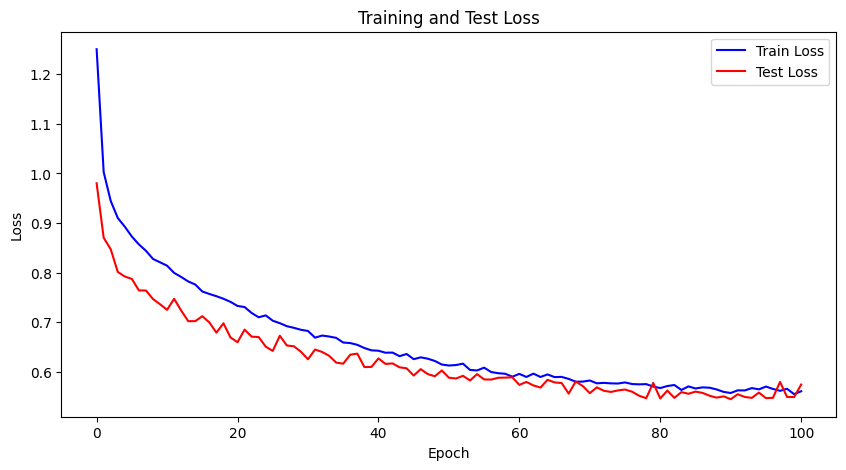

In [37]:
input_size = 65
hidden_layers = [256, 128, 64]
num_gaussians = 3
dropout = 0.5
lr = 0.0001

model = MDN(65, [256, 128, 64], 3, 0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

num_epochs = 101
train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, num_epochs, device)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')
plt.show()

In [46]:
model.eval()

with torch.no_grad():
    sample = X_test_scaled[10].reshape(1, -1)
    sample_tensor = torch.tensor(sample, dtype=torch.float32).to(device)
    pi, mu, sigma = model(sample_tensor)
    pi = np.array(pi.cpu())
    mu = np.array(mu.cpu())
    sigma = np.array(sigma.cpu())

mu = y_scaler.inverse_transform(mu)
sigma = sigma * y_scaler.scale_[0]

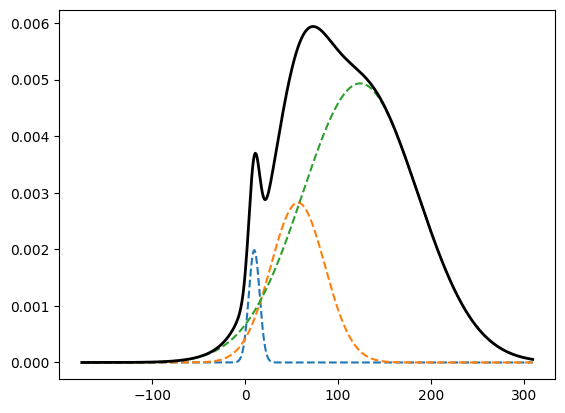

In [47]:
x = np.linspace(mu.min() - 3*sigma.max(), mu.max() + 3*sigma.max(), 500)

total = np.zeros_like(x)
for i in range(len(pi[0])):
    component = pi[0][i] * norm.pdf(x, mu[0][i], sigma[0][i])
    plt.plot(x, component, '--')
    total += component

plt.plot(x, total, 'k-', linewidth=2)
plt.show()

In [43]:
player_key = 'McCaCh01'
year = 2024

index = data[(data['Key'] == player_key) & (data['Year'] == year)].index[0]
player_data = data.iloc[[index]]
player_data

,Key,Player,Year,Age,Exp_3,Exp_2,Exp_1,num_games_3,num_games_2,num_games_1,...,ProBowl_3,ProBowl_2,ProBowl_1,AllPro_3,AllPro_2,AllPro_1,Pos_RB,Pos_TE,Pos_WR,Points_half-ppr
13075,McCaCh01,Christian McCaffrey,2024,28,4,5,6,17,17,17,...,0,1,1,0,0,1,1,0,0,40.3


Mu: [[109.15539 261.6531  233.97638]]
Sigma: [[ 2.804532 58.676575 85.806435]]
Pi: [[4.2832512e-11 2.4502107e-05 9.9997544e-01]]


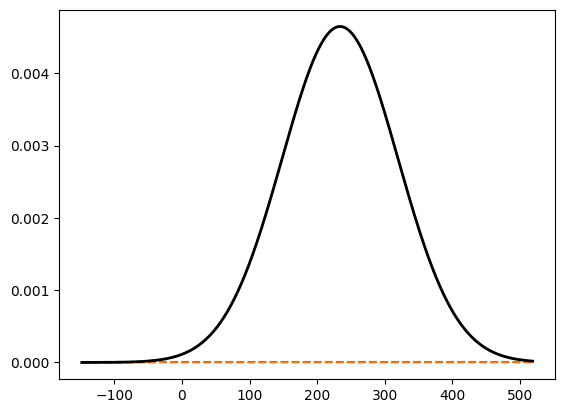

In [45]:
features = player_data.iloc[:, 2:-1]
X_scaled = scaler.transform(features)

model.eval()
with torch.no_grad():
    sample = X_scaled.reshape(1, -1)
    sample_tensor = torch.tensor(sample, dtype=torch.float32).to(device)
    pi, mu, sigma = model(sample_tensor)
    pi = np.array(pi.cpu())
    mu = np.array(mu.cpu())
    sigma = np.array(sigma.cpu())

mu = y_scaler.inverse_transform(mu)
sigma = sigma * y_scaler.scale_[0]

print(f'Mu: {mu}')
print(f'Sigma: {sigma}')
print(f'Pi: {pi}')

x = np.linspace(mu.min() - 3*sigma.max(), mu.max() + 3*sigma.max(), 500)

total = np.zeros_like(x)
for i in range(len(pi[0])):
    component = pi[0][i] * norm.pdf(x, mu[0][i], sigma[0][i])
    plt.plot(x, component, '--')
    total += component

plt.plot(x, total, 'k-', linewidth=2)
plt.show()